In [44]:
# 927110
# Space Research and Technology
# 925120
# Administration of Urban Planning and Community and Rural Development
# 922140
# Correctional Institutions

import os, glob
import pandas as pd
import requests
import bs4
import json
import time
from datetime import datetime
import zipfile
import matplotlib.pyplot as plt

def Get_API_Github_Definition(url_test_api):
    pass
    # need to use selenium to get the "here" link to github code
    return
    
#TEST
Get_API_Github_Definition("https://api.usaspending.gov/api/v2/award_spending/recipient/?fiscal_year=2016&awarding_agency_id=183")
    
def Get_API_Endpoints():

    url_root = "https://api.usaspending.gov"
    
    r = requests.get("https://api.usaspending.gov/docs/endpoints")

    #r.content

    soup = bs4.BeautifulSoup(r.content, features="html.parser")

    results_list = []

    table = soup.find('table')
    thead = table.find('thead').find('tr')
#     for header in thead:
#         print(header)
#         # gather header titles
    for tr in table.find_all('tr'):
        elements = []
        for td in tr.find_all('td'):
            for a in td.find_all('a'):
                try:
                    elements.append(url_root + a['href'])
                    #print("...", a['href']) #, a['href'])
                except:
                    pass
                    #print(a)
            #print(td.text)
            elements.append(td.text)
            
        if elements:
            results_list.append({'url_test_api' : elements[0], 'Endpoint' : elements[1], 'Methods' : elements[2], 'Description' : elements[3]})
        #print()
    df = pd.DataFrame(results_list)
    df['Endpoint_Labels'] = df['Endpoint'].apply(lambda x: "_".join(x.split("/")[3:])[0:-1])
    return df

# df_api_endpoints = Get_API_Endpoints()
# print(df_api_endpoints)

class USAspending(): 
    #TODO: refactor and simplify the code (the code in several of the methods is redundant and should be streamlined) for maintainability 
    #TODO: add more tests to confirm it is working correctly and reliably

    url_root = 'https://api.usaspending.gov' #!! note it is api.usaspending.gov NOT www.usaspending.gov
    api = {}
    api['parent_child'] = '/api/v2/recipient/children/' #'/DUNS'
    api['recipient_spending_category'] = '/api/v2/search/spending_by_category/recipient_duns/'
    api['recipient_overview'] = "/api/v2/recipient/duns/"
    api['autocomplete_psc'] = "/api/v2/autocomplete/funding_psc/"
    api['autocomplete_funding_agency'] = "/api/v2/autocomplete/funding_agency/"
    api['autocomplete_glossary'] = "/api/v2/autocomplete/glossary/"
    api['bulk_download_awards'] = "/api/v2/bulk_download/awards/"
    api['bulk_download_list_agencies'] = "/api/v2/bulk_download/list_agencies/"
    api['bulk_download_status'] = "/api/v2/bulk_download/status/"
    
    USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0"
    USER_AGENT = "XY" #solves 406 error on redirect of the biden mailer click link # 
    headers = {"user-agent" : USER_AGENT}

    def __init__(self,):
        pass # this __init__ can include variables set up at the creation of the object for this class, TBD
    
    def Get_URL_API(self, api_name, contents=""):
        if contents == '':
          return self.url_root + self.api[api_name]
        else:
          return self.url_root + self.api[api_name] + contents + '/'
               
    def API_Check_Status(self, requests_response):
        #print(requests_response)
        if requests_response.status_code == 200:
            return json.loads(requests_response.content)
        else:
            return "Error - response:", requests_response.status_code, requests_response.reason

    def API_Get_Parent_Child_Details_Using_DUNS(self, aDUNS):   

        api_name = 'parent_child'
        url_api = self.Get_URL_API(api_name, contents = aDUNS)
        #print(url_api)
        r = requests.get(url_api)
        #print(r)

        return self.API_Check_Status(r)

    def API_Overview_Recipient_ID(self, recipient_id):

        api_name = 'recipient_overview'
        url_api = self.Get_URL_API(api_name, contents = recipient_id)

        #print(url_api)
        r = requests.get(url_api, headers= self.headers)
        #print(r)
        return self.API_Check_Status(r)


    def API_Name_Search(self, pattern):
        print("...querying USAspending.gov API...")
        
        api_name = 'recipient_spending_category'
        url_api = self.Get_URL_API(api_name)

        #print(url_api)
        page = 1
        next_page = True
        
        results = []
        
        while next_page:
            print(f'page:{page}', end=",")
            payload = {"page" : page, "filters": {"recipient_search_text": [pattern]}}
            r = requests.post(url_api, json=payload) # note this is a POST
            #print(r)
            result_record = API_Check_Status(r)
            results.append(result_record)
        
        # insert code here (turn it into a function) that keeps reading pages until 'hasNext' == False
            page += 1
            next_page = result_record['page_metadata']['hasNext']
        
        self.name_search_results = results
        
        return self.API_Check_Status(r)

    def Autocomplete_psc(self, search_text):
      return

    def Autocomplete_funding_agency(self, search_text):
      headers = {'Content-Type': 'application/json'}
      payload = {'search_text' : search_text}
      api_name = 'autocomplete_funding_agency'
      url_api = self.Get_URL_API(api_name)
      r = requests.post(url_api, headers= headers, json=payload)
      return self.API_Check_Status(r)

    def Autocomplete_glossary(self, search_text):
      payload = {'search_text' : search_text}
      api_name = 'autocomplete_glossary'
      url_api = self.Get_URL_API(api_name)
      r = requests.post(url_api, json=payload)
      return self.API_Check_Status(r)

    
    def Bulk_Download(self, body = {}):
      headers = {'Content-Type': 'application/json'}
      payload = body
      print(f"body: {body}")
      api_name = "bulk_download_awards"
      url_api = self.Get_URL_API(api_name)
      print(f"url_api: {url_api}")

      r = requests.post(url_api, headers=headers, json=payload)
      return self.API_Check_Status(r)

    def Bulk_Download_list_agencies(self, body = {}):
      headers = {'Content-Type': 'application/json'}
      payload = body
      print(f"body: {body}")
      api_name = "bulk_download_list_agencies"
      url_api = self.Get_URL_API(api_name)
      print(f"url_api: {url_api}")

      r = requests.post(url_api, headers= headers, json=payload)
      return self.API_Check_Status(r)

    def Bulk_Download_status(self, body = {}):
      headers = {'Content-Type': 'application/json'}
      payload = body
      print(f"body: {body}")
      api_name = 'bulk_download_status'
      url_api = self.Get_URL_API(api_name) + "?file_name=" + body['file_name']
      print(f"url_api: {url_api}")

      r = requests.get(url_api) #! GET not POST
      return self.API_Check_Status(r)
    
    def API_Process_POST_Response(self, api_post_json):

        return_value = []
        #print(api_post_json.keys())
        next_page = api_post_json['page_metadata']['hasNext'] #!!!TODO change this to handle MULTIPLE Pages
        results = api_post_json['results']
        print(f"results:{results}")
        parent_id_list = []
        for recipient in results:
            info_record = self.API_Overview_Recipient_ID(recipient['recipient_id'])
            return_value.append(info_record)
            if info_record['parent_id']: #adds the parent to the records returned

                if not info_record['parent_id'] in parent_id_list:
                    return_value.append(self.API_Overview_Recipient_ID(info_record['parent_id']))
                    parent_id_list.append(info_record['parent_id'])

        return pd.DataFrame(return_value)

#### END CLASS

In [45]:

spending = USAspending()

body = {
"type":"account_agencies"
}
list_departments_independent_agencies = spending.Bulk_Download_list_agencies(body = body)

[record for record in list_departments_independent_agencies['agencies']['cfo_agencies'] if record['name'] == 'Department of Defense']

body: {'type': 'account_agencies'}
url_api: https://api.usaspending.gov/api/v2/bulk_download/list_agencies/


[{'name': 'Department of Defense',
  'toptier_agency_id': 126,
  'toptier_code': '097'}]

In [46]:
body =  {
      "filters": {
          "agency": 126, #HHS
        #   "sub_agency" : "Centers for Medicare and Medicaid Services",
          "prime_award_types": [
                                  "IDV_A",
                                  "IDV_B",
                                  "IDV_B_A",
                                  "IDV_B_B",
                                  "IDV_B_C",
                                  "IDV_C",
                                 "IDV_D",
                                  "IDV_E",
                                  "02",
                                  "03",
                                  "04",
                                  "05",
                                  "06",
                                  "07",
                                  "08",
                                  "09",
                                  "10",
                                  "11",
                                  "A",
                                  "B",
                                  "C",
                                  "D",
                              ],
          #"keyword" : "", #optional
          "date_range": {
              "start_date": "2023-01-01",
              "end_date": "2022-01-01"
          },
          "date_type": "action_date"
      }
  }
download_info = spending.Bulk_Download(body = body)
download_info

body: {'filters': {'agency': 126, 'prime_award_types': ['IDV_A', 'IDV_B', 'IDV_B_A', 'IDV_B_B', 'IDV_B_C', 'IDV_C', 'IDV_D', 'IDV_E', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', 'A', 'B', 'C', 'D'], 'date_range': {'start_date': '2023-01-01', 'end_date': '2022-01-01'}, 'date_type': 'action_date'}}
url_api: https://api.usaspending.gov/api/v2/bulk_download/awards/


{'status_url': 'https://api.usaspending.gov/api/v2/download/status?file_name=All_PrimeTransactions_2023-10-28_H17M41S54720952.zip',
 'file_name': 'All_PrimeTransactions_2023-10-28_H17M41S54720952.zip',
 'file_url': 'https://files.usaspending.gov/generated_downloads/All_PrimeTransactions_2023-10-28_H17M41S54720952.zip',
 'download_request': {'download_types': ['prime_awards'],
  'file_format': 'csv',
  'filters': {'agencies': [{'name': 'Department of Defense',
     'tier': 'toptier',
     'type': 'awarding'}],
   'prime_and_sub_award_types': {'prime_awards': ['02',
     '03',
     '04',
     '05',
     '06',
     '07',
     '08',
     '09',
     '10',
     '11',
     'A',
     'B',
     'C',
     'D',
     'IDV_A',
     'IDV_B',
     'IDV_B_A',
     'IDV_B_B',
     'IDV_B_C',
     'IDV_C',
     'IDV_D',
     'IDV_E']},
   'time_period': [{'date_type': 'action_date',
     'end_date': '2022-01-01',
     'start_date': '2023-01-01'}]},
  'request_type': 'award'}}

In [47]:
download_file_name = download_info['file_name']

body = {
    'file_name' : download_file_name
}

download_status = spending.Bulk_Download_status(body = body)

while download_status['status'] != 'finished':
  print(datetime.now(),download_file_name, download_status['status'], f"elapsed seconds: {download_status['seconds_elapsed']}")
  print('...sleeping...')
  time.sleep(5)
  download_status = spending.Bulk_Download_status(body = body)

body: {'file_name': 'All_PrimeTransactions_2023-10-28_H17M41S54720952.zip'}
url_api: https://api.usaspending.gov/api/v2/bulk_download/status/?file_name=All_PrimeTransactions_2023-10-28_H17M41S54720952.zip


In [48]:
import requests

# Define the API endpoint URL
base_url = "https://api.usaspending.gov/api/v2/search/spending_by_category/naics/"
naics_code = "927110"
url = f"{base_url}{naics_code}"

payload = {
    "filters": {
        "time_period": [
            {
                "start_date": "2022-01-01",
                "end_date": "2023-01-01"
            }
        ],
        "naics_codes": {
            "require": ["927110"]
        }
    },
    "category": "naics",
    # "page": 1
}

response = requests.post(url, json=payload)

if response.status_code == 200:
    data = response.json()
    # Now, you can work with the data
    print(data)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


{'category': 'naics', 'limit': 10, 'page_metadata': {'page': 1, 'next': None, 'previous': None, 'hasNext': False, 'hasPrevious': False}, 'results': [{'id': None, 'code': '927110', 'name': 'Space Research and Technology', 'amount': 72803255.36}], 'messages': ['For searches, time period start and end dates are currently limited to an earliest date of 2007-10-01.  For data going back to 2000-10-01, use either the Custom Award Download feature on the website or one of our download or bulk_download API endpoints as listed on https://api.usaspending.gov/docs/endpoints.']}


# Spending Data Function #

In [65]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_spending_data(start_date, end_date, naics_code):
    # Define the API endpoint URL
    base_url = "https://api.usaspending.gov/api/v2/search/spending_by_category/naics/"

    url = f"{base_url}{naics_code}"

    # Construct the payload
    payload = {
        "filters": {
            "time_period": [
                {
                    "start_date": start_date,
                    "end_date": end_date
                }
            ],
            "naics_codes": {
                "require": [naics_code]
            }
        },
        "category": "naics",
        "limit": 5,
        "page": 1
    }

    # Make the API request
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return None
    
def annual_spending_range(start_year, end_year, naics_code):
    annual_spending = {}

    for year in range(start_year, end_year):
        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"  

        result = get_spending_data(start_date, end_date, naics_code)
        
        if result:
            annual_spending[year] = result['results'][0]['amount']

    return annual_spending

def plot_annual_spending(start_year, end_year, naics_code):
    
    data = annual_spending_range(start_year, end_year, naics_code)

    years = list(data.keys())
    amounts = list(data.values())
    df = pd.DataFrame({'Year': years, 'Amount': amounts})

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = ax = sns.barplot(x="Year", y="Amount", hue="Amount", data=df, palette="Blues_d", legend=False)

    plt.xlabel('Year')
    plt.ylabel('Amount')
    title = f'NAICS Code {naics_code} Spending Over the Years'
    plt.title(title)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

    plt.show()

In [70]:
print(get_spending_data("2010-01-01", "2021-01-01", "927110"))

{'category': 'naics', 'limit': 5, 'page_metadata': {'page': 1, 'next': None, 'previous': None, 'hasNext': False, 'hasPrevious': False}, 'results': [{'id': None, 'code': '927110', 'name': 'Space Research and Technology', 'amount': 6117491924.87}], 'messages': ['For searches, time period start and end dates are currently limited to an earliest date of 2007-10-01.  For data going back to 2000-10-01, use either the Custom Award Download feature on the website or one of our download or bulk_download API endpoints as listed on https://api.usaspending.gov/docs/endpoints.']}


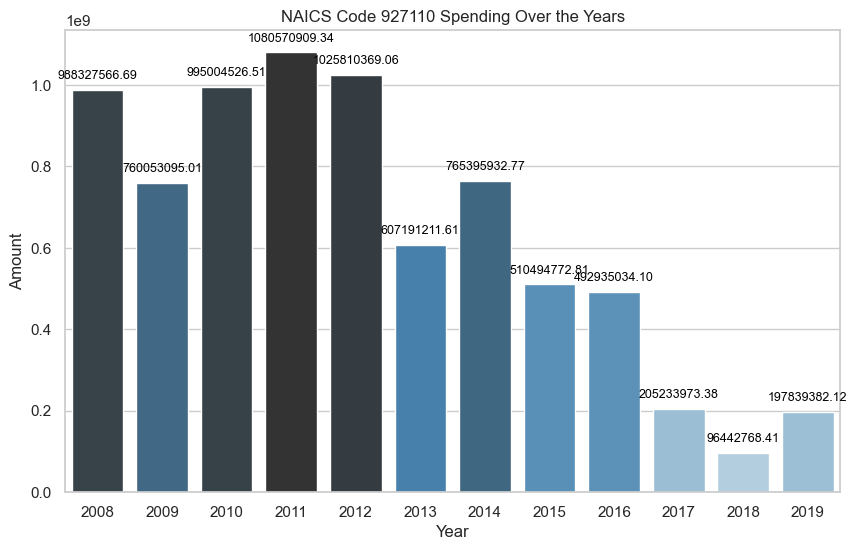

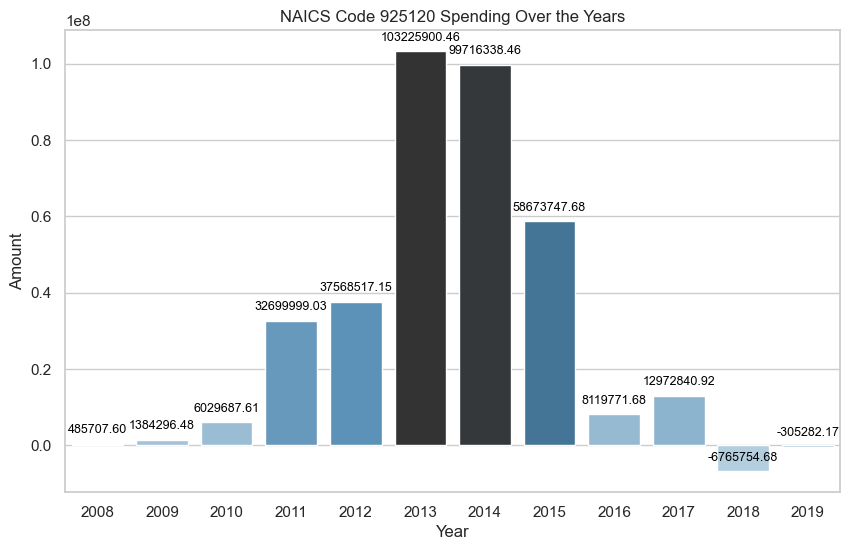

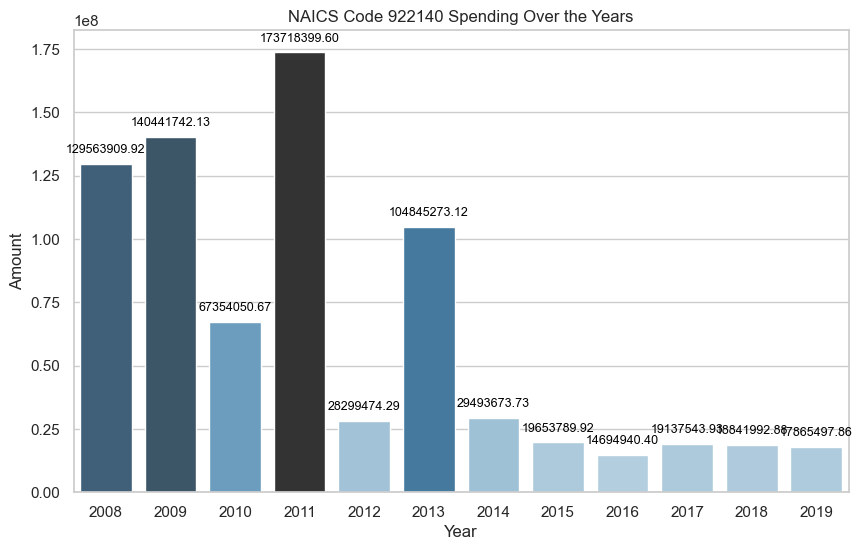

In [66]:
plot_annual_spending(2008, 2020, "927110")
plot_annual_spending(2008, 2020, "925120")
plot_annual_spending(2008, 2020, "922140")